# GLM data prep

Create a table of data for each recording.
Each row is a millisecond (data only from bouts).
Variables include speeds + shifted speeds, curvature of the track, firing rate...


In [1]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
from fcutils.progress import track
from fcutils.maths import derivative
from scipy import stats
from fcutils.maths.signals import rolling_mean
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")


from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")

cache = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM\data")

REGION = "CUN/PPN"
recordings = get_recording_names(region=REGION)
recordings

[06/21/22 15:16:41] DEBUG    DPL - Saving data and logs to logs                   ]8;id=490483;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=220110;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#118\118]8;;\

                    DEBUG    Saving log file to: logs\log.log                     ]8;id=876680;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py\core.py]8;;\:]8;id=377612;file://c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\tpd\core.py#119\119]8;;\

Connecting root@127.0.0.1:3306


[06/21/22 15:16:43] DEBUG    Connected to database: LOCOMOTION4                ]8;id=520129;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py\__init__.py]8;;\:]8;id=669262;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\data\dbase\__init__.py#11\11]8;;\

array(['FC_210715_AAA1110750_r5_hairpin',
       'FC_210716_AAA1110750_r6_hairpin', 'FC_210720_AAA1110750_hairpin',
       'FC_210721_AAA1110750_hairpin', 'FC_210722_AAA1110750_hairpin',
       'FC_211022_BAA110516_hairpin', 'FC_211027_BAA110516_hairpin',
       'FC_211214_BAA110517_hairpin', 'FC_220114_BAA110517_hairpin',
       'FC_220117_BAA110517_hairpin', 'FC_220119_BAA110517_hairpin',
       'FC_220120_BAA110517_hairpin', 'FC_210917_BAA1110279_hairpin',
       'FC_210820_BAA1110281_hairpin', 'FC_210829_BAA1110281_hairpin',
       'FC_210830_BAA1110281_hairpin', 'FC_210831_BAA1110281_hairpin',
       'FC_210901_BAA1110281_hairpin', 'FC_210906_BAA1110281_hairpin',
       'FC_210917_BAA1110281_hairpin'], dtype=object)

## Parameters

In [2]:
curvature_horizon = 30
curvature_sampling_spacing = 5
curv_sample_points = np.arange(0, curvature_horizon+curvature_sampling_spacing, curvature_sampling_spacing)

track_downsample_factor = 25

firing_rate_gaussian = 250 # width in ms

### Track curvature
Sample the track curvature for N future positions given each track position

In [3]:
track_data = pd.read_json(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\track.json").iloc[::track_downsample_factor]
track_data = track_data.reset_index(drop=True)
S_f = track_data.S.values[-1]
track_data

,S,X,Y,curvature,width,θ
0,0.000000,20.005419,32.926672,1.397851e-08,3.600000,-1.562696
1,0.034248,20.005696,32.892425,2.407125e-04,3.596612,-1.562692
2,0.068464,20.005974,32.858210,4.834723e-04,3.590541,-1.562680
3,0.102616,20.006251,32.824059,7.303402e-04,3.584550,-1.562659
4,0.136672,20.006529,32.790004,9.834296e-04,3.578645,-1.562630
...,...,...,...,...,...,...
3996,265.273224,3.999664,7.342840,3.530815e-05,3.600000,-1.570627
3997,265.334935,3.999675,7.281129,2.648609e-05,3.600000,-1.570625
3998,265.396642,3.999685,7.219422,1.766084e-05,3.600000,-1.570624
3999,265.458347,3.999696,7.157717,8.831522e-06,3.600000,-1.570623


In [4]:
# load track from json
k_shifts = np.arange(curvature_horizon+1)
curv_shifted = {
    **{f"k_{k}":[] for k in k_shifts},
    **{f"idx_{k}":[] for k in k_shifts},
}
for i, s in enumerate(track_data.S):
    for k in k_shifts:
        if s + k < S_f:
            select = track_data.loc[track_data.S >= s + k]
            curv_shifted[f"idx_{k}"].append(select.index[0])
            curv_shifted[f"k_{k}"].append(select["curvature"].iloc[0])
        else:
            curv_shifted[f"k_{k}"].append(np.nan)
            curv_shifted[f"idx_{k}"].append(np.nan)

    # break

for k,v in curv_shifted.items():
    track_data.insert(2, k, rolling_mean(v, 201))
track_data.head()

,S,X,idx_30,idx_29,idx_28,idx_27,idx_26,idx_25,idx_24,idx_23,...,k_5,k_4,k_3,k_2,k_1,k_0,Y,curvature,width,θ
0,0.000000,20.005419,490.653465,477.683168,464.782178,452.099010,439.554455,427.247525,415.059406,402.980198,...,0.009219,0.011521,0.012443,0.011602,0.008703,0.007673,32.926672,1.397851e-08,3.600000,-1.562696
1,0.034248,20.005696,491.039216,478.068627,465.156863,452.470588,439.931373,427.617647,415.421569,403.333333,...,0.009038,0.011397,0.012390,0.011604,0.008764,0.007746,32.892425,2.407125e-04,3.596612,-1.562692
2,0.068464,20.005974,491.427184,478.446602,465.533981,452.844660,440.300971,427.980583,415.786408,403.689320,...,0.008856,0.011270,0.012334,0.011603,0.008823,0.007819,32.858210,4.834723e-04,3.590541,-1.562680
3,0.102616,20.006251,491.817308,478.826923,465.913462,453.221154,440.673077,428.346154,416.144231,404.048077,...,0.008673,0.011142,0.012274,0.011600,0.008880,0.007895,32.824059,7.303402e-04,3.584550,-1.562659
4,0.136672,20.006529,492.209524,479.209524,466.295238,453.600000,441.047619,428.714286,416.504762,404.409524,...,0.008489,0.011010,0.012210,0.011594,0.008935,0.007971,32.790004,9.834296e-04,3.578645,-1.562630


get distance from the next curve apex based on the direction of travel

,S,X,idx_30,idx_29,idx_28,idx_27,idx_26,idx_25,idx_24,idx_23,...,k_5,k_4,k_3,k_2,k_1,k_0,Y,curvature,width,θ
495,32.524252,16.609437,937.029851,921.398010,905.741294,890.094527,874.447761,858.800995,843.109453,827.407960,...,-0.147310,-0.158054,-0.166702,-0.173053,-0.176860,-0.177820,2.778840,-0.190115,3.078853,-3.011064
1291,86.961710,20.414862,1733.547264,1717.910448,1702.303483,1686.701493,1671.114428,1655.532338,1639.925373,1624.303483,...,-0.115269,-0.119982,-0.123500,-0.125917,-0.126999,-0.126650,48.986140,-0.132793,3.484434,-6.298832
2060,138.983899,31.232525,2506.223881,2490.572139,2474.925373,2459.273632,2443.597015,2427.930348,2412.233831,2396.532338,...,0.155876,0.168608,0.179209,0.186475,0.190414,0.190698,3.323494,0.197759,3.009291,-6.493340
2878,192.908819,32.570976,3335.532338,3320.437811,3305.273632,3290.313433,3275.323383,3260.353234,3245.353234,3230.228856,...,0.067185,0.076811,0.085064,0.090703,0.093861,0.094184,52.731760,0.125779,3.324384,-3.847031
3285,219.671416,7.143928,3751.034826,3735.378109,3719.691542,3704.064677,3688.422886,3672.731343,3657.129353,3641.492537,...,0.073137,0.081276,0.087055,0.090676,0.092262,0.092457,52.285322,0.137347,3.362902,-2.336674


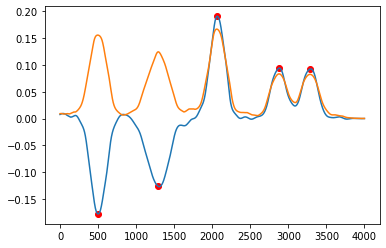

In [5]:
from scipy.signal import find_peaks

k = rolling_mean(np.abs(track_data.curvature.values), 251)
peaks, _ = find_peaks(k, prominence=0.02)

plt.plot(track_data.k_0)
plt.plot(k)
plt.scatter(peaks, track_data.k_0[peaks], color="red")


peaks_idxs, _ = find_peaks(k, prominence=0.02)
peaks = track_data.iloc[peaks]
peaks

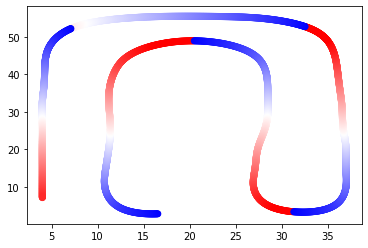

In [6]:
apex_distance = dict(
    outward=[], invard=[],
)

for i, row in track_data.iterrows():
    # find next peak with larger s
    next_peak = peaks[peaks.S > row.S]
    if len(next_peak) > 0:
        # get distance from it
        next_peak = next_peak.iloc[0]
        apex_distance["outward"].append(next_peak.S - row.S)
    else:
        apex_distance["outward"].append(np.nan)

    # get distance from previous peak
    prev_peak = peaks[peaks.S < row.S]
    if len(prev_peak) > 0:
        prev_peak = prev_peak.iloc[-1]
        apex_distance["invard"].append(row.S - prev_peak.S)
    else:
        apex_distance["invard"].append(np.nan)

f, ax  = plt.subplots()
ax.scatter(
    track_data["X"], track_data["Y"], c=apex_distance["invard"], cmap="bwr", vmin=0, vmax=50
)

track_data["apex_distance_outward"] = apex_distance["outward"]
track_data["apex_distance_inward"] = apex_distance["invard"]

## Process data

In [7]:

def upsample_frames_to_ms(var):
    """
        Interpolates the values of a variable expressed in frams (60 fps)
        to values expressed in milliseconds.
    """
    t_60fps = np.arange(len(var)) / 60
    f = interpolate.interp1d(t_60fps, var)

    # t_1000fps = np.arange(0, t_60fps[-1], step=1/1000)
    t_200fps = np.arange(0, t_60fps[-1], step=1/200)
    interpolated_variable_values = f(t_200fps)
    return interpolated_variable_values


In [8]:

def gaussian(x, s):
    return (
        1.0
        / np.sqrt(2.0 * np.pi * s ** 2)
        * np.exp(-(x ** 2) / (2.0 * s ** 2))
    )


def calc_firing_rate(spikes_train: np.ndarray, dt: int = 10):
    """
        Computes the firing rate given a spikes train (wether there is a spike or not at each ms).
        Using a gaussian kernel with standard deviation = dt/2 [dt is in ms]
    """
    # create kernel & get area under the curve
    k = np.array([gaussian(x, dt / 2) for x in np.linspace(-2*dt, 2*dt, dt)])
    auc = np.trapz(k)

    # get firing rate
    frate = (
        np.convolve(spikes_train, k, mode="same") / auc * 1000
    )  # times 1000 to go from ms to seconds

    
    return frate[::5]  # sample every 5 ms -> 200 fps
    # return frate


def make_shuffled_units(units):
    """
        For each unit make shuffled copies in which 
        the firing rate is offset by some ammount looping
        around the start/end of the session
    """
    N = 100
    shuffled_units = dict(unit_id=[], firing_rate_ms=[])
    for i, unit in units.iterrows():
        for n in range(N):
            shuffle = np.random.randint(10 * 200, 100 * 200)  # shuffle between 10 and 30 seconds
            shuffled_units["unit_id"].append(f"{unit.unit_id}_shuffle_{n}")

            frate = unit.firing_rate_ms
            frate = np.hstack([frate[shuffle:], frate[:shuffle]])
            shuffled_units["firing_rate_ms"].append(frate)

    # merge units and shuffle units in a single dataframe
    shuffled_units = pd.DataFrame(shuffled_units)
    units = pd.concat([units, shuffled_units], ignore_index=True)
    return units

#### main data loader

In [9]:
# upsample
def load_get_recording_data(REC): 
    # load data
    units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    if not len(units):
        print(f"No units found for {REC}")
        return None, None, None, None, None, None, None, None,  None, None, None

    out_bouts = get_session_bouts(REC, complete=None)
    in_bouts = get_session_bouts(REC, direction="inbound", complete=None)

    v = upsample_frames_to_ms(body.speed)
    omega = upsample_frames_to_ms(body.thetadot)

    ms_per_frame = 1000 / 200
    _250ms = int(250 / ms_per_frame)
    _500ms = int(500 / ms_per_frame)
    _1000ms = int(1000 / ms_per_frame)

    v_250ms = np.hstack([v[_250ms:], v[_250ms] * np.ones(_250ms)]) - v
    v_500ms = np.hstack([v[_500ms:], v[_500ms] * np.ones(_500ms)]) - v
    v_1000ms = np.hstack([v[_1000ms:], v[_1000ms] * np.ones(_1000ms)]) - v

    omega_500ms = np.hstack([omega[_500ms:], omega[_500ms] * np.ones(_500ms)]) - omega
    omega_250ms = np.hstack([omega[_250ms:], omega[_250ms] * np.ones(_250ms)]) - omega
    omega_1000ms = np.hstack([omega[_1000ms:], omega[_1000ms] * np.ones(_1000ms)]) - omega


    # get unit firing rate in milliseconds
    if REGION == "MOs":
        units = units.loc[units.brain_region.isin(["MOs", "MOs1", "MOs2/3", "MOs5", "MOs6a", "MOs6b"])]
    else:
        units = units.loc[units.brain_region.isin(["CUN", "PPN"])]

    frates = []
    for i, unit in units.iterrows():
        time = np.zeros(len(v) * 5)  # time in milliseconds
        spikes_times = np.int64(np.round(unit.spikes_ms))
        spikes_times = spikes_times[spikes_times < len(time)]
        time[spikes_times] = 1
        frates.append(calc_firing_rate(time, dt=firing_rate_gaussian))  # firing rate at 200fps
    units["firing_rate_ms"] = frates
    units = units[["unit_id", "firing_rate_ms"]]  # discard unnecessary columns

    # add shuffled units
    units = make_shuffled_units(units)

    return units, body, pd.concat([out_bouts, in_bouts]).reset_index(), v, omega, v_250ms, omega_250ms, v_500ms, omega_500ms, v_1000ms, omega_1000ms

### Collect data for all bouts

In [15]:
# first, for each recording and each bout save a .h5 file. 
# Then load it back and merge them toghether. This is to avoid memory issues.

recordings = ["FC_210901_BAA1110281_hairpin", "FC_210917_BAA1110281_hairpin", "FC_210721_AAA1110750_hairpin"]

for n, REC in enumerate(recordings):
    if (cache / f"{REC}_bouts.h5").exists():
        print(f"{REC}_bouts.h5 already exists")
        continue
    print(f"Processing {REC} ({n+1}/{len(recordings)})")

    units, body, bouts, v, omega, v_250ms, omega_250ms, v_500ms, omega_500ms, v_1000ms, omega_1000ms = load_get_recording_data(REC)

    if units is None:
        continue
    print(f"     got all data > {len(bouts)} bouts, {len(units)} units")

    for i, bout in track(bouts.iterrows(), total=len(bouts), description=REC):
        bout_savepath = cache / f"{REC}_bout_{bout.start_frame}.h5"
        if bout_savepath.exists():
            print(f"{REC}_bout_{bout.start_frame}.h5 already exists")
            continue

        data = {
            **dict(
                s=[],
                apex_distance=[],
                v=[],
                dv_250ms=[],
                dv_500ms=[],
                dv_1000ms=[],
                omega=[],
                domega_250ms=[],
                domega_500ms=[],
                domega_1000ms=[],
            ),
            **{f"curv_{k}cm":[] for k in curv_sample_points},
            **{unit:[] for unit in units.unit_id.values},
        }


        S = upsample_frames_to_ms(bout.s)
        data['s'].extend(S)

        # get distance from apex
        dist = track_data["apex_distance_outward"] if bout.direction == "outward" else track_data["apex_distance_inward"]
        for s in S:
            idx = np.argmin((track_data.S - s)**2)
            data['apex_distance'].append(dist[idx])


        start_ms = int(bout.start_frame / 60 * 200)
        end_ms = start_ms + len(S)
        data['v'].extend(v[start_ms : end_ms])
        data['dv_250ms'].extend(v_250ms[start_ms : end_ms])
        data['dv_500ms'].extend(v_500ms[start_ms : end_ms])
        data['dv_1000ms'].extend(v_1000ms[start_ms : end_ms])
        data['omega'].extend(omega[start_ms : end_ms])
        data['domega_250ms'].extend(omega_250ms[start_ms : end_ms])
        data['domega_500ms'].extend(omega_500ms[start_ms : end_ms])
        data['domega_1000ms'].extend(omega_1000ms[start_ms : end_ms])

        # get firing rate
        for i, unit in units.iterrows():
            data[unit.unit_id].extend(unit.firing_rate_ms[start_ms : end_ms])

        # get curvature
        for k_cm in curv_sample_points:
            for s in S:
                idx = np.argmin((track_data.S - s)**2)
                data[f"curv_{k_cm}cm"].append(track_data[f"k_{k_cm}"][idx])


        # ensure all entries have the same number of samples
        lengths = set([len(v) for v in data.values()])
        if len(lengths) > 1:
            lns = {k:len(v) for k,v in data.items()}        
            raise ValueError(f"Lengths of data are not the same:\n{lns}")

    
        pd.DataFrame(data).to_hdf(bout_savepath, key="data")
        del data

    del units
    del body
    del bouts

    



Processing FC_210901_BAA1110281_hairpin (1/3)
No units found for FC_210901_BAA1110281_hairpin
Processing FC_210917_BAA1110281_hairpin (2/3)
     got all data > 0 bouts, 808 units


Output()

FC_210917_BAA1110281_hairpin Completed:  Completed 0/0   0% • Speed:  • Remaining:  Elpsed:

Processing FC_210721_AAA1110750_hairpin (3/3)
No units found for FC_210721_AAA1110750_hairpin


In [14]:
for REC in recordings:
    savepath = cache / f"{REC}_bouts.h5"
    if savepath.exists():
        print(f"{REC}_bouts.h5 already exists")
        continue
    
    print(f"Doing   {REC}")
    out_bouts = get_session_bouts(REC, complete=None)
    in_bouts = get_session_bouts(REC, direction="inbound", complete=None)
    allbouts = pd.concat([out_bouts, in_bouts]).reset_index()

    bouts_files = list(cache.glob(f"{REC}_bout_*.h5"))
    if len(bouts_files) < len(allbouts):
        print(f"    Not all bouts were saved for {REC}")
        continue

    bouts_data = []
    for i, bout in allbouts.iterrows():
        f = cache / f"{REC}_bout_{bout.start_frame}.h5"
        if not f.exists():
            break
        try:
            bouts_data.append(pd.read_hdf(f, key="data"))
        except AttributeError:
            print(f"    {f} was too hard to read")
            continue
        
    if not len(bouts_data):
        print(f"    No bouts were saved for {REC}")
        continue
    bouts_data = pd.concat(bouts_data)

    # print(f" Got all data ({bouts_data.shape}), removing outliers")
    # del out_bouts; del in_bouts; del allbouts
    # bouts_data[(np.abs(stats.zscore(bouts_data)) < 3).all(axis=1)]


    print(" Saving data")
    bouts_data.to_hdf(savepath, key="data")
    print(" Saved all data")


FC_210715_AAA1110750_r5_hairpin_bouts.h5 already exists
FC_210716_AAA1110750_r6_hairpin_bouts.h5 already exists
FC_210720_AAA1110750_hairpin_bouts.h5 already exists
Doing   FC_210721_AAA1110750_hairpin
    Not all bouts were saved for FC_210721_AAA1110750_hairpin
FC_210722_AAA1110750_hairpin_bouts.h5 already exists
FC_211022_BAA110516_hairpin_bouts.h5 already exists
FC_211027_BAA110516_hairpin_bouts.h5 already exists
FC_211214_BAA110517_hairpin_bouts.h5 already exists
FC_220114_BAA110517_hairpin_bouts.h5 already exists
FC_220117_BAA110517_hairpin_bouts.h5 already exists
FC_220119_BAA110517_hairpin_bouts.h5 already exists
FC_220120_BAA110517_hairpin_bouts.h5 already exists
FC_210917_BAA1110279_hairpin_bouts.h5 already exists
FC_210820_BAA1110281_hairpin_bouts.h5 already exists
FC_210829_BAA1110281_hairpin_bouts.h5 already exists
FC_210830_BAA1110281_hairpin_bouts.h5 already exists
FC_210831_BAA1110281_hairpin_bouts.h5 already exists
Doing   FC_210901_BAA1110281_hairpin
    Not all bouts